# Scenario 5 modelling

The scenario 5 turns brownfield and industrial areas around the river within Newcastle or nearby into public parks. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily 
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import matplotlib.cm
import mapclassify
import husl
import seaborn as sns

from utils import legendgram
import demoland_engine

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_3335/897323822.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

### Importing extra data

For this scenarios, we need the brownfield data.

The brownfield layer (points) downloaded from https://www.planning.data.gov.uk/map/ was edited in Qgis:
- Only OAs containing brownfield were selected, in order to obtain a list of them
- this selectio of OAs was then categorised as either 'urban' or 'suburban'

In [3]:
brownfield_OAs = gpd.read_file(f"{data_folder}/scenarios/OAs_tynewear_contains-brownfield.gpkg")

## Output area level

The scenario is defined via four variables (signature type, use, green space, job types) for every output area. You can start from the `empty.parquet` that contains the structure and is filled with `None`. When values for a single OA are all `None`, we do not alter any underlying value and use what is currently observed. When we specify a value for use, green space or job types, the algorithm updates the existing observed values accordingly. When we change a signature type to a different type than is currently observed, we sample the values from the country-wide distribution. The changes of se, green space or job types in such a case adapt these sampled values.

In [4]:
df = demoland_engine.get_empty()
df.head()

signature_type   use greenspace job_types
geo_code                                           
E00042786           None  None       None      None
E00042707           None  None       None      None
E00042703           None  None       None      None
E00042782           None  None       None      None
E00042789           None  None       None      None

When all values are `None`, the `get_indicators` function retrieves the baseline data reflecting the current state and predicts on that.

See the docstring of `get_indicators` to understand how what the values in individual columns mean.

With a DataFrame set to all None, we can retrieve a baseline prediction.

In [5]:
%%time
default = demoland_engine.get_indicators(df, random_seed=42)

CPU times: user 4.59 s, sys: 465 ms, total: 5.06 s
Wall time: 5.03 s


In [6]:
default.head()

air_quality  house_price  job_accessibility  \
geo_code                                                 
E00042786    17.534467     7.481114             2313.0   
E00042707    15.588646     7.966569            12862.0   
E00042703    16.377251     7.700036             1548.0   
E00042782    17.483731     7.424853             3310.0   
E00042789    16.850696     7.374106             2267.0   

           greenspace_accessibility  
geo_code                             
E00042786              273920.09500  
E00042707              298640.16545  
E00042703              505787.49050  
E00042782              253491.99240  
E00042789              219076.32555

When you change the information, either the adaptation of existing values (like in case of `greenspace` or `job_types`) or drawing of new values from a known distribution happens.

## Implementation:

Allocate areas of "Industrial or commercial units" along the rivers to parks.

1. Select OAs with some brownfield areas based on the registry.
2. Manually limit the selection to areas around the river or some other large-scale brownfield areas in the vicinity of city centre.
3. Assign new green space to those areas.

In [7]:
brownfield_OAs.explore()

## scenario 5

In [8]:
scenario5 = df.copy()
scenario5.loc[scenario5.index.isin(brownfield_OAs.geo_code), "greenspace"] = .9

Then we get indicators based on a specified scenario.

In [9]:
%%time
changed_5 = demoland_engine.get_indicators(scenario5, random_seed=42)

CPU times: user 4.18 s, sys: 438 ms, total: 4.62 s
Wall time: 4.46 s


## Maps

You can plot the two results.

In [10]:
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

In [11]:
from shapely.geometry import box

bds = geom.total_bounds
extent = gpd.GeoSeries([box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=geom.crs).to_crs(3857)

### Air quality

Text(0.5, 1.0, 'baseline air quality')

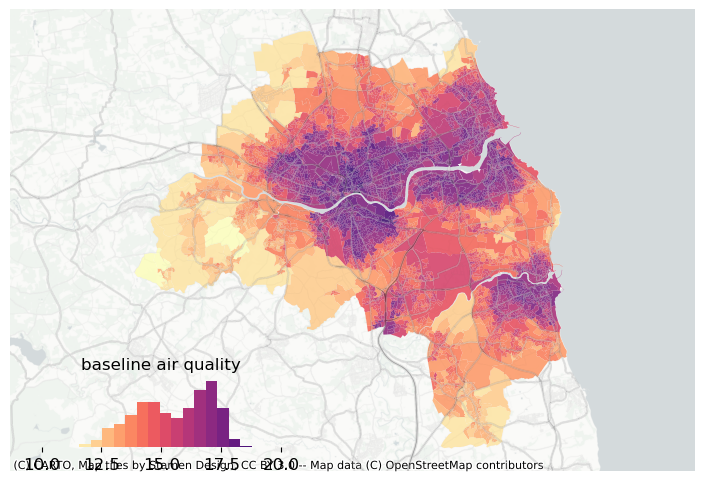

In [12]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.EqualInterval(default.air_quality.values, k=20).bins

legendgram(
    f,
    ax,
    default.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline air quality")


Text(0.5, 1.0, 'Scenario 5 air quality')

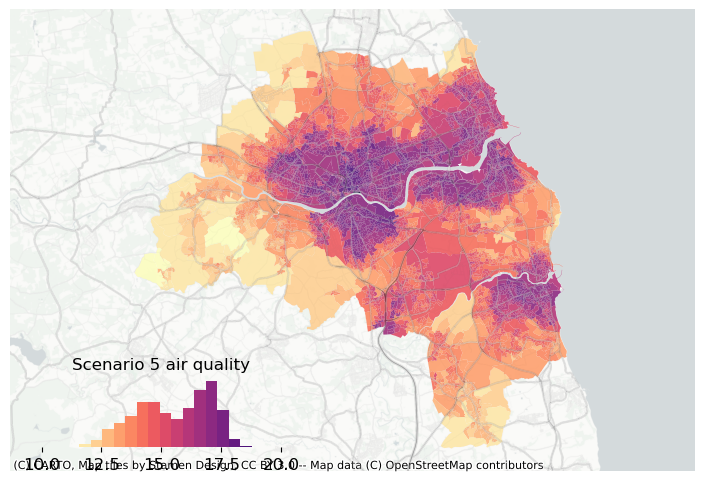

In [13]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_5.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_5.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 5 air quality")


Text(0.5, 1.0, 'Air quality change')

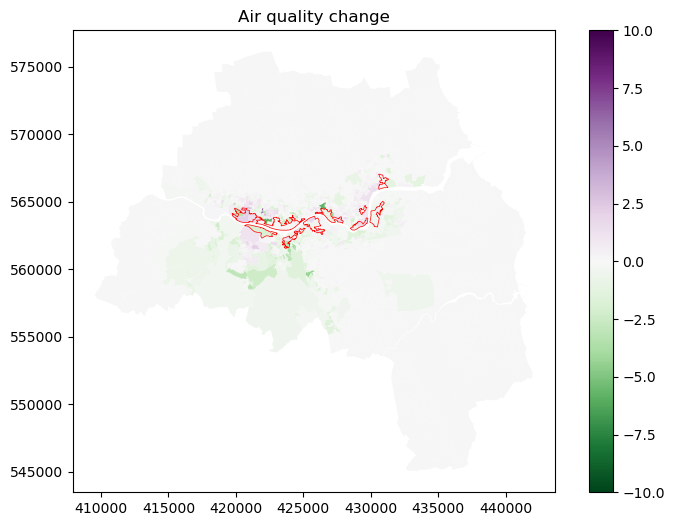

In [14]:
ax = geom.plot((changed_5.air_quality.values - default.air_quality.values) / default.air_quality.values * 100, legend=True, cmap="PRGn_r", vmin=-10, vmax=10, figsize=(9, 6))
brownfield_OAs.dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Air quality change")

### House price

Text(0.5, 1.0, 'baseline house price')

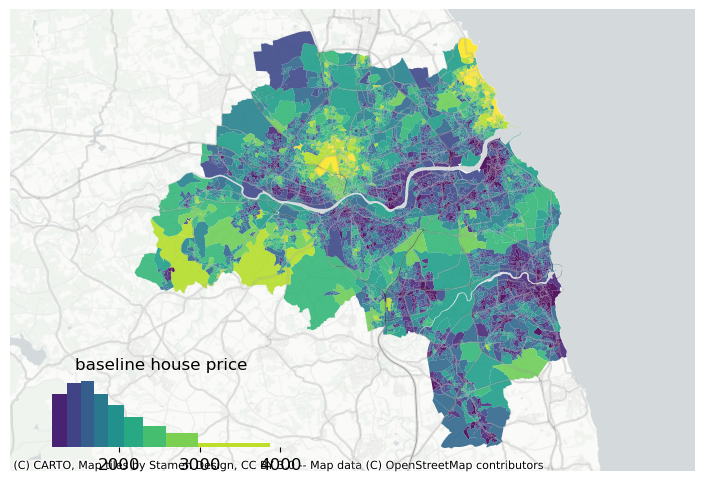

In [15]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(np.exp(default["house_price"].values), k=10).bins

legendgram(
    f,
    ax,
    np.exp(default.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(default.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline house price")


Text(0.5, 1.0, 'Scenario 5 house price')

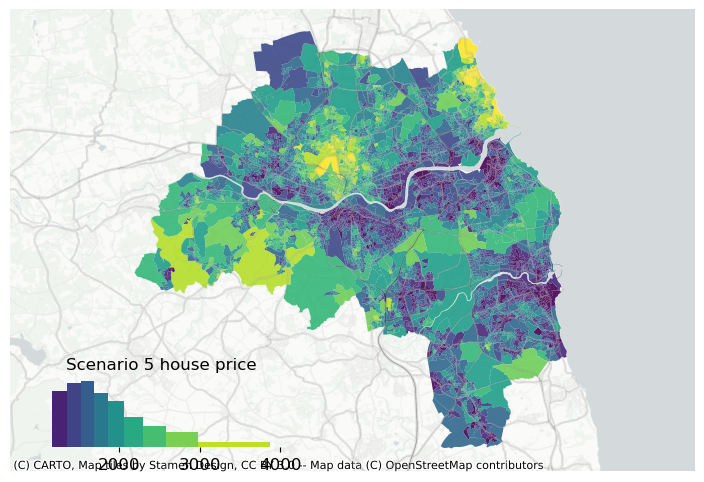

In [16]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    np.exp(changed_5.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(changed_5.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 5 house price")


Text(0.5, 1.0, 'House price change')

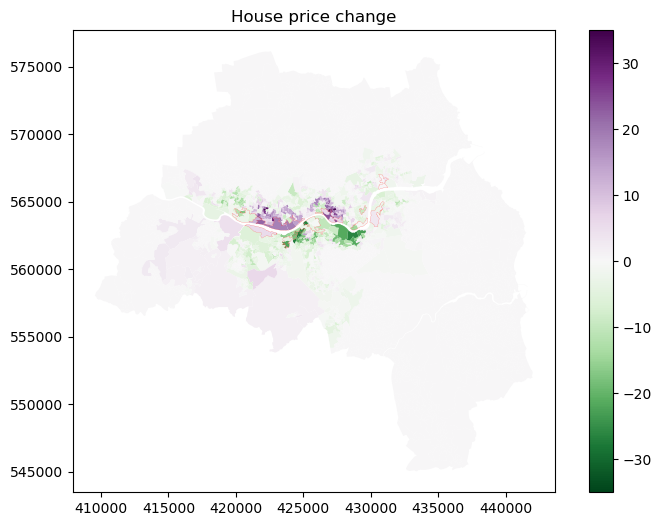

In [17]:
ax = geom.plot((np.exp(changed_5.house_price.values) - np.exp(default.house_price.values)) / np.exp(default.house_price.values) * 100, legend=True, cmap="PRGn_r", vmin=-35, vmax=35, figsize=(9, 6))
brownfield_OAs.dissolve().boundary.plot(ax=ax, color="red", linewidth=.1)
ax.set_title("House price change")

### Job accessibility

Text(0.5, 1.0, 'baseline job accessibility')

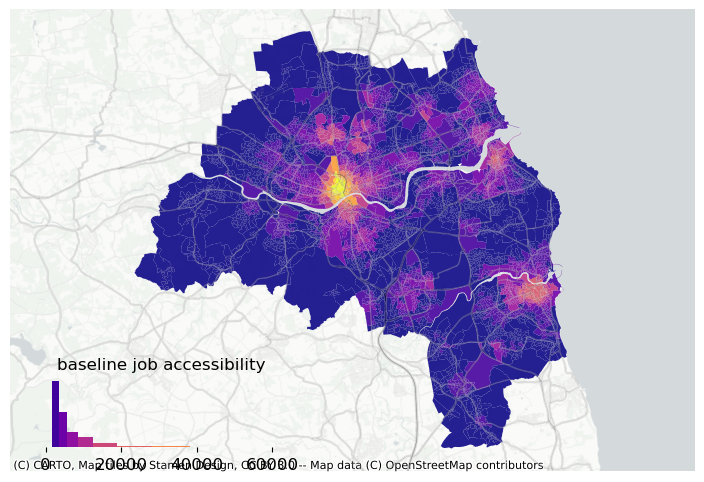

In [18]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.job_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline job accessibility")


Text(0.5, 1.0, 'Scenario 5 job accessibility')

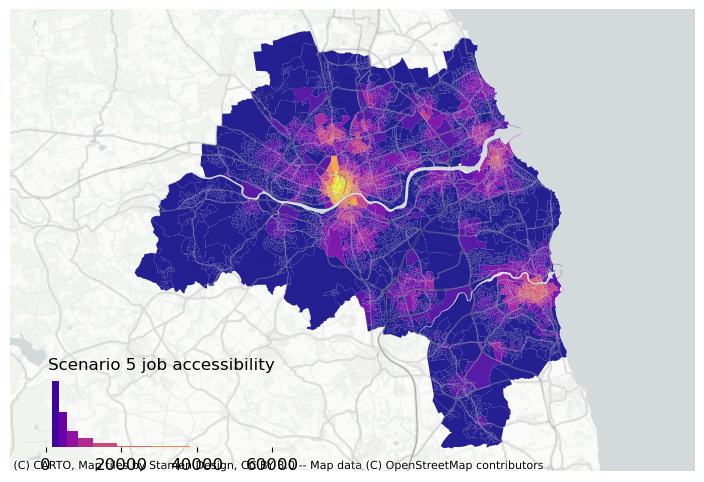

In [19]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_5.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_5.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 5 job accessibility")


Text(0.5, 1.0, 'Job accessibility change')

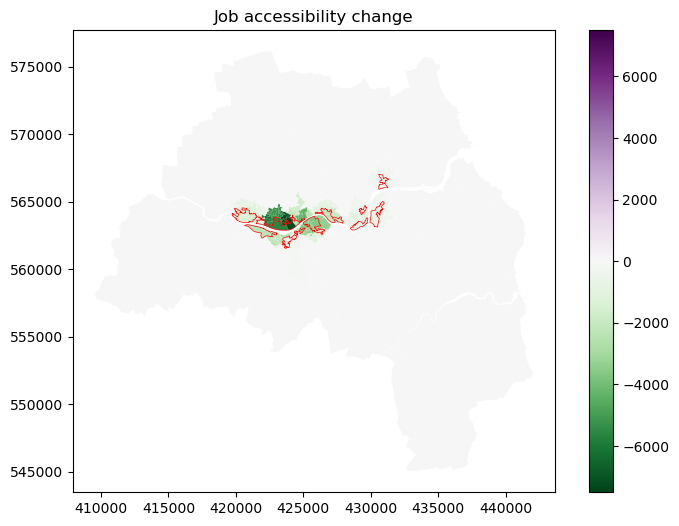

In [20]:
ax = geom.plot((changed_5.job_accessibility.values - default.job_accessibility.values), legend=True, cmap="PRGn_r", figsize=(9, 6), vmin=-7500, vmax=7500)
brownfield_OAs.dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Job accessibility change")

### Greenspace accessibility

Text(0.5, 1.0, 'baseline green space accessibility')

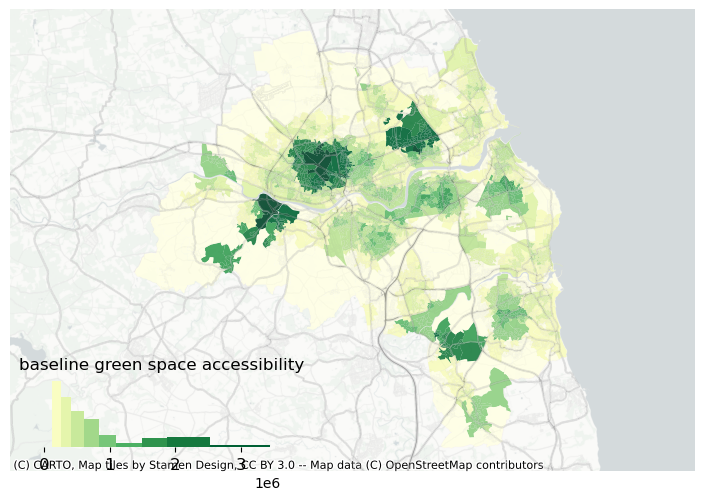

In [21]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.greenspace_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline green space accessibility")


Text(0.5, 1.0, 'Scenario 5 green space accessibility')

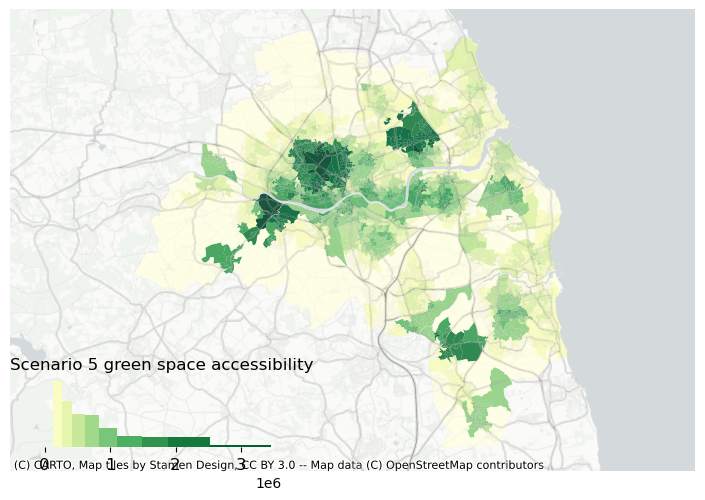

In [22]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_5.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_5.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 5 green space accessibility")


Text(0.5, 1.0, 'Green space accessibility change')

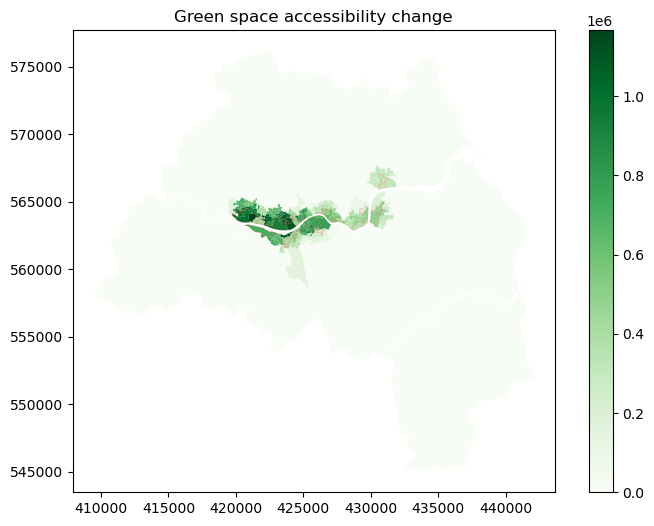

In [23]:
ax = geom.plot(changed_5.greenspace_accessibility.values - default.greenspace_accessibility.values, legend=True, cmap="Greens", figsize=(9, 6))
brownfield_OAs.dissolve().boundary.plot(ax=ax, color="red", linewidth=.1)
ax.set_title("Green space accessibility change")

In [24]:
exvars, _, _ = demoland_engine.sampling.get_data(df)
exvars_sc, _, _ = demoland_engine.sampling.get_data(scenario5)

In [25]:
(exvars == exvars_sc).all()

population_estimate                                                               False
A, B, D, E. Agriculture, energy and water                                         False
C. Manufacturing                                                                  False
F. Construction                                                                   False
G, I. Distribution, hotels and restaurants                                        False
H, J. Transport and communication                                                 False
K, L, M, N. Financial, real estate, professional and administrative activities    False
O,P,Q. Public administration, education and health                                False
R, S, T, U. Other                                                                 False
Land cover [Discontinuous urban fabric]                                           False
Land cover [Continuous urban fabric]                                              False
Land cover [Non-irrigated arable